# image classification
## overview 
use cnn to classify image to judge it is a cat or dog
## requirements
- use image generator
- use data augmentation
- use cnn
- predict picture

## import module 

In [ ]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import shutil
from shutil import copyfile

In [ ]:
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [ ]:
tf.__version__

'2.4.1'

In [ ]:
tf.device('/GPU:0')

## read image data 

In [ ]:
!rm -r /tmp/dog_cat_classification

In [ ]:
# This code block downloads the full Cats-v-Dogs dataset and stores it as 
# cats-and-dogs.zip. It then unzips it to /tmp
# which will create a tmp/PetImages directory containing subdirectories
# called 'Cat' and 'Dog' (that's how the original researchers structured it)
# If the URL doesn't work, 
# .   visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

print('num dog',len(os.listdir('/tmp/PetImages/Dog')))
print('num cat',len(os.listdir('/tmp/PetImages/Cat')))

--2021-05-11 12:23:14--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 173.222.228.51, 2600:1409:12:285::e59, 2600:1409:12:2af::e59
Connecting to download.microsoft.com (download.microsoft.com)|173.222.228.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   100MB/s    in 9.2s    

2021-05-11 12:23:23 (85.8 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]

num dog 12501
num cat 12501


In [ ]:
import imghdr
file_li = os.listdir('/tmp/PetImages/Dog')
len([file for file in file_li if imghdr.what('/tmp/PetImages/Dog/'+file ) == 'jpeg'])

12349

In [ ]:
base_dir = '/tmp/dog_cat_classification/'
dir_li = [
          base_dir
          ,base_dir+'train'
          ,base_dir+'valid'
          ,base_dir+'train/dog'
          ,base_dir+'train/cat'
          ,base_dir+'valid/dog'
          ,base_dir+'valid/cat'
]

for dir in dir_li:
  if not os.path.exists(dir ):
    os.mkdir(dir)
    print('mkdir',dir)

mkdir /tmp/dog_cat_classification/
mkdir /tmp/dog_cat_classification/train
mkdir /tmp/dog_cat_classification/valid
mkdir /tmp/dog_cat_classification/train/dog
mkdir /tmp/dog_cat_classification/train/cat
mkdir /tmp/dog_cat_classification/valid/dog
mkdir /tmp/dog_cat_classification/valid/cat


In [ ]:
# split data 
dir_dog = '/tmp/PetImages/Dog'
dir_cat = '/tmp/PetImages/Cat'
dog_file_li = os.listdir(dir_dog)
cat_file_li = os.listdir(dir_cat)

def split_and_copy_data(src,dst_train,dst_valid , train_ratio):
  files = os.listdir(src)
  files = [file for file in files if imghdr.what(src+'/' +file ) == 'jpeg']
  files = random.sample(files , len(files))
  
  train_size = int(len(files) * train_ratio)
  train_files = files[:train_size]
  valid_files = files[train_size:]

  for train_file in train_files:
    copyfile(src+'/'+train_file , dst_train +'/'+train_file )
  for valid_file in valid_files:
    copyfile(src+'/'+valid_file , dst_valid +'/'+valid_file)

split_and_copy_data(dir_dog,base_dir+'train/dog',base_dir+'valid/dog' , 0.9)
split_and_copy_data(dir_cat,base_dir+'train/cat',base_dir+'valid/cat' , 0.9)


In [ ]:
for dir in dir_li:
  print(dir,'len : ',len(os.listdir(dir)))


/tmp/dog_cat_classification/ len :  2
/tmp/dog_cat_classification/train len :  2
/tmp/dog_cat_classification/valid len :  2
/tmp/dog_cat_classification/train/dog len :  11114
/tmp/dog_cat_classification/train/cat len :  11146
/tmp/dog_cat_classification/valid/dog len :  1235
/tmp/dog_cat_classification/valid/cat len :  1239


## create image generator

In [ ]:
train_image_gen = ImageDataGenerator(
     rotation_range=40, 
     width_shift_range=0.2, 
     height_shift_range=0.2, 
     shear_range=0.2, 
     zoom_range=0.2, 
     fill_mode='nearest', 
     horizontal_flip=True, 
     vertical_flip=True, 
     rescale=1./255, 
     )
valid_image_gen = ImageDataGenerator(
     rotation_range=40, 
     width_shift_range=0.2, 
     height_shift_range=0.2, 
     shear_range=0.2, 
     zoom_range=0.2, 
     fill_mode='nearest', 
     horizontal_flip=True, 
     vertical_flip=True, 
     rescale=1./255, 
     
     )

train_data = train_image_gen.flow_from_directory(
    directory = base_dir+'train'
    ,target_size = (28,28)
    ,batch_size = 32
    # ,shuffle=True
    ,class_mode = 'binary'
    # ,save_format='jpg'
)
valid_data = valid_image_gen.flow_from_directory(
    directory = base_dir+'valid'
    ,target_size = (28,28)
    ,batch_size = 32
    # ,shuffle=True
    ,class_mode = 'binary'
    # ,save_format='jpg'
)


Found 22260 images belonging to 2 classes.
Found 2474 images belonging to 2 classes.


## create model

In [ ]:

from tensorflow.keras.layers import *

model = tf.keras.models.Sequential()

model.add(Conv2D(input_shape = (28,28,3) ,filters = 64,kernel_size = (4,4),activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64,kernel_size = (3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64,kernel_size = (2,2),activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = 1 , activation = 'sigmoid'))

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 64)        3136      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          16448     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

In [ ]:
class myCallbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs = {}):
    if logs.get('accuracy') >= 0.99:
      print('accuracy reached to 99%')
      self.model.stop_training = True


In [ ]:
callbacks = myCallbacks()

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit_generator(
      train_data
      ,epochs=10
      ,validation_data = valid_data
      ,verbose = 1
      ,callbacks = callbacks
  )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
228/696 [========>.....................] - ETA: 43s - loss: 0.6956 - accuracy: 0.5065

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

696/696 [==============================] - 75s 103ms/step - loss: 0.6906 - accuracy: 0.5275 - val_loss: 0.6538 - val_accuracy: 0.6200
Epoch 2/10
696/696 [==============================] - 71s 103ms/step - loss: 0.6674 - accuracy: 0.5979 - val_loss: 0.6286 - val_accuracy: 0.6354
Epoch 3/10
696/696 [==============================] - 71s 102ms/step - loss: 0.6439 - accuracy: 0.6311 - val_loss: 0.6110 - val_accuracy: 0.6564
Epoch 4/10
696/696 [==============================] - 71s 102ms/step - loss: 0.6322 - accuracy: 0.6359 - val_loss: 0.6041 - val_accuracy: 0.6867
Epoch 5/10
696/696 [==============================] - 73s 105ms/step - loss: 0.6242 - accuracy: 0.6481 - val_loss: 0.6028 - val_accuracy: 0.6681
Epoch 6/10
696/696 [==============================] - 73s 105ms/step - loss: 0.6126 - accuracy: 0.6621 - val_loss: 0.5793 - val_accuracy: 0.6940
Epoch 7/10
696/696 [==============================] - 73s 104ms/step - loss: 0.6123 - accuracy: 0.6657 - val_loss: 0.6059 - val_accuracy: 0.6

In [ ]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

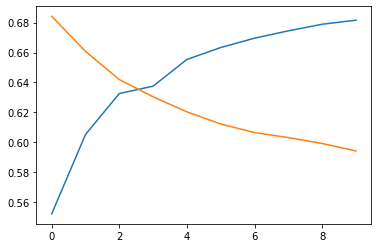

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

In [ ]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(28，28））
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")